We will now investigate solutions to Poisson's equation:

$$
\nabla^2 V(\mathbf{r}) = \sum_i \frac{\partial^2 V}{\partial r_i^2} = -\alpha\rho(\mathbf{r})
$$

for potential $V$ and source density $\rho$. In the case of Coulomb's law, $\rho$ is the charge density and $V$ is the electric potential, with $\alpha = 1/\epsilon_0$.  


We will investigate both **relaxation** and **Fourier** solutions

In [63]:
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

In [64]:
import numpy as np
import time
import cmath

class Poisson :
    def __init__ (self, L, rho_init, method, calcError = True):
        self.L = L                    # number of interior points in x and y
        self.omega = 1.88177          # over-relaxation parameter for L = 50
        self.N = L + 2                # interior plus two boundary points
        N=self.N
        self.V = np.zeros( (N, N) )   # potential to be found
        self.VNew = np.zeros( (N, N) )# new potential after each step
        self.h = 1.0 / (L + 1)        # lattice spacing assuming size in x and y = 1
        self.nsmooth = 3              # smoothing steps for multigrid method
        self.rho = np.array( rho_init )
        self.method=method        
        self.calcError = calcError
        self.error  = 0. if self.calcError else None
        self.errors = [] if self.calcError else None


    def __call__(self):
        return getattr(self,self.method)()

    def update(self):
        if self.calcError :
            self.error = np.sum( np.abs(self.V - self.VNew) ) / self.V.size
        self.V[:,:] = self.VNew[:,:]
        if self.calcError :
            self.errors.append(self.error)
            return self.error
        else :
            return None

        
    def Jacobi(self) :
        '''
        Jacobi algorithm for a single iterative step
        '''
        self.VNew = self.JacStep(self.VNew,self.V,self.h,self.rho)
        return self.update()

    def JacStep(self, u, v, h, rho):
        '''
        Jacobi algorithm on arbitrary inputs. Called once by "Jacobi".
        Called many times by "MultiGrid"
        '''
        u[1:-1,1:-1] = np.add.reduce([
            0.25*v[1:-1, 2:] ,
            0.25*v[1:-1, 0:-2],
            0.25*v[2:,   1:-1] ,
            0.25*v[0:-2, 1:-1] ,
            h**2 * rho[1:-1,1:-1]])
        return u

            
    def GaussSeidel(self):
        ''' 
        Gauss-Seidel algorithm for one iterative step
        '''
        self.VNew[:,:] = self.V[:,:]
        # perform Gauss-Seidel update
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                self.VNew[i][j] = 0.25 * (self.VNew[i-1][j] + self.VNew[i+1][j] +
                                            self.VNew[i][j-1] + self.VNew[i][j+1] +
                                            self.h**2 * self.rho[i][j])
        return self.update()


    def SuccessiveOverRelaxation(self):
        '''
        Averages between G-S and J methods. 
        '''

        # update even sites in red-black scheme
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                if (i + j) % 2 == 0:
                    self.VNew[i][j] = (1 - self.omega) * self.V[i][j] + self.omega / 4 * (
                                 self.V[i-1][j] + self.V[i+1][j] + self.V[i][j-1] +
                                 self.V[i][j+1] + self.h**2 * self.rho[i][j] )

        # update odd sites in red-black scheme
        for i in range(1, self.L+1):
            for j in range(1, self.L+1):
                if (i + j) % 2 != 0:
                    self.VNew[i][j] = (1 - self.omega) * self.V[i][j] + self.omega / 4 * (
                                 self.VNew[i-1][j] + self.VNew[i+1][j] + self.VNew[i][j-1] +
                                 self.VNew[i][j+1] + self.h**2 * self.rho[i][j] )
        return self.update()


    def FFT(self):
        '''
        Explicitly solves differential equation in Fourier domain
        '''
        
        # Make a grid to get indices
        x = np.arange(self.N)
        y = np.arange(self.N)
        xx,yy = np.meshgrid(x,y)
        # Construct root of unity
        i = 0. + 1.j
        W = cmath.exp( 2 * i * cmath.pi / float(self.N) )
        # Get the denominator using the grid
        d = 4.0 - np.power(W, xx ) - np.power(W, -xx) - np.power(W, yy) - np.power(W, -yy)
        valid_d = (d > 0.0)
        # FFT of rho columns
        rhof = np.fft.fft(self.rho, axis=0)
        # FFT of rho rows
        rhof = np.fft.fft(rhof,axis=1)
        # Solve for V in Fourier domain
        Vf = np.divide( rhof * self.h**2, d, out=np.zeros_like(d, dtype=complex), where=np.absolute(d)>0)
        # IFFT of V rows
        self.V = np.fft.ifft( Vf, axis=0)
        # IFFT of V columns
        self.V = np.fft.ifft( self.V, axis=1)
        return 



In [65]:
L = 50
N = L+2
q = 10.0                # point charge
i = N // 2                    # center of lattice
h = 1/(L+1)
rho = np.zeros( (N,N))
rho[i,i+13] = q / h**2    # charge density
rho[i,i-13] = -q / h**2    # charge density

nsteps = 100
steps = np.arange(nsteps)
p = Poisson(L,rho, 'Jacobi')
for i in steps : 
    p()

Text(0.5, 0, 'y')

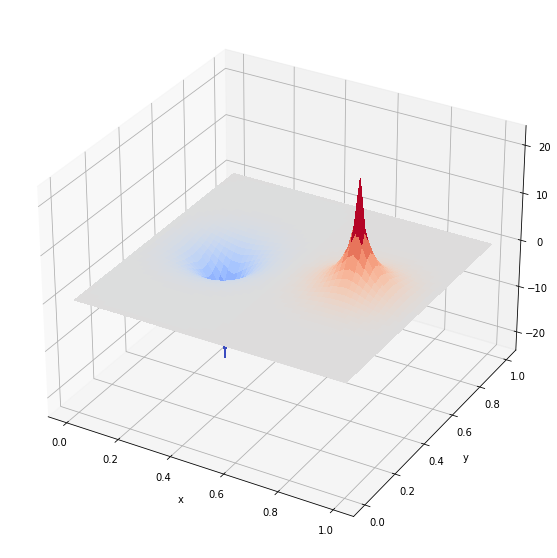

In [66]:
# Define the axes
x = np.arange(0, p.h*(p.L+2), p.h)
y = np.arange(0, p.h*(p.L+2), p.h)
# Get the grid
X, Y = np.meshgrid(x, y)
# Set Z to the poisson V[i][j]
Z = np.array( p.V )

fig = plt.figure(1,figsize=(10, 10))
ax = fig.gca(projection='3d')
sur = ax.plot_surface( X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False )
plt.xlabel("x")
plt.ylabel("y")

In [67]:
methods = ["Jacobi"]
#methods = ["Jacobi", "GaussSeidel", "SuccessiveOverRelaxation"]
solvers = []
times = np.zeros( len(methods))
for i,method in enumerate(methods) : 
    p = Poisson(L,rho, method)
    err = []
    t1 = time.perf_counter()    
    for j in steps : 
        ierr = p()
    t2 = time.perf_counter()
    solvers.append(p)
    times[i] = (t2-t1)
    print("Method %40s processed %d steps in %6.5f  s" % (method, len(steps), times[i]) )

Method                                   Jacobi processed 100 steps in 0.03511  s


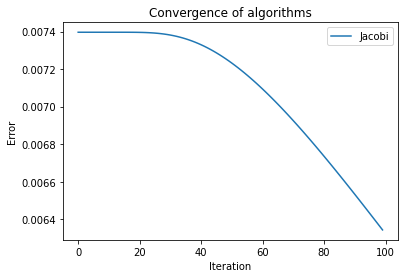

In [68]:
fig = plt.figure(2)
for i,method in enumerate(methods) :     
    plt.plot(steps, solvers[i].errors, label=method )
plt.title("Convergence of algorithms")
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.legend()
plt.show()

In [69]:
solvers = []
acc = 1e-6
times = np.zeros( len(methods))
for i,method in enumerate(methods) : 
    p = Poisson(L,rho, method)
    err = []
    ierr = 9999.
    t1 = time.perf_counter()
    while ierr > acc :    
        ierr = p()
    t2 = time.perf_counter()
    solvers.append(p)
    times[i] = (t2-t1)
    print("Accuracy %6.2e reached in %6.5f  s" % (acc, times[i]) )

Accuracy 1.00e-06 reached in 0.86000  s


Text(0.5, 0, 'y')

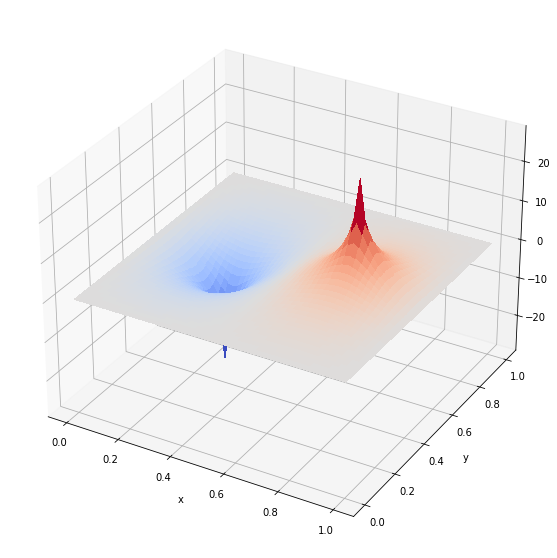

In [70]:
# Set Z to the poisson V[i][j]
Z = np.array( p.V.real )

fig = plt.figure(2,figsize=(10,10))
ax = fig.gca(projection='3d')
sur = ax.plot_surface( X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False )
plt.xlabel("x")
plt.ylabel("y")